In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import shap

In [98]:
# Loaded dataset
dataset = pd.read_csv('/content/f_dataset.csv')
dataset.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,critical_temp
0,37.454012,95.071431,73.199394,59.865848,15.601864,15.599452,5.808361,86.617615,60.111501,70.807258,...,13.949386,29.214465,36.636184,45.606998,78.517596,19.967378,51.423444,59.241457,4.645041,9.165924
1,60.754485,17.052412,6.505159,94.888554,96.563203,80.839735,30.461377,9.767211,68.423303,44.015249,...,77.513282,93.949894,89.482735,59.789998,92.187424,8.849250,19.598286,4.522729,32.533033,9.502136
2,38.867729,27.134903,82.873751,35.675333,28.093451,54.269608,14.092422,80.219698,7.455064,98.688694,...,62.329813,33.089802,6.355835,31.098232,32.518332,72.960618,63.755747,88.721274,47.221493,0.044101
3,11.959425,71.324479,76.078505,56.127720,77.096718,49.379560,52.273283,42.754102,2.541913,10.789143,...,16.122129,92.969765,80.812038,63.340376,87.146059,80.367208,18.657006,89.255900,53.934224,3.170750
4,80.744016,89.609130,31.800347,11.005192,22.793516,42.710779,81.801477,86.073058,0.695213,51.074730,...,25.178230,49.724851,30.087831,28.484049,3.688695,60.956433,50.267902,5.147875,27.864646,8.373780


In [99]:
# look and remove the missing data
missing_data = dataset.isnull().sum().sum()
print(f"Total missing values: {missing_data}")
dataset = dataset.dropna()

Total missing values: 0


In [100]:
# Handle outliers  :- IQR method
q1 = dataset.quantile(0.25)
q3 = dataset.quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

In [101]:
# Filter out rows with outliers
dataset = dataset[~((dataset < lower_limit) | (dataset > upper_limit)).any(axis=1)]
print(f"Dataset shape after removing outliers: {dataset.shape}")

Dataset shape after removing outliers: (1200, 31)


In [102]:
# Define features and target variable
X_data = dataset.drop(columns=["critical_temp"])
y_data = dataset["critical_temp"]

In [103]:
# Scale the features
scaler = StandardScaler()
X_scaled_data = scaler.fit_transform(X_data)

In [104]:
# Feature selection using Recursive Feature Elimination (rfe)
lr_model = LinearRegression()
feature_selector = RFE(lr_model, n_features_to_select=10)
X_selected_data = feature_selector.fit_transform(X_scaled_data, y_data)
selected_features_list = X_data.columns[feature_selector.support_]
print(f"Selected features: {selected_features_list}")

Selected features: Index(['feature_3', 'feature_5', 'feature_10', 'feature_11', 'feature_13',
       'feature_14', 'feature_16', 'feature_18', 'feature_24', 'feature_30'],
      dtype='object')


In [105]:
# Split the data into training and test sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_selected_data, y_data, test_size=0.2, random_state=42)

In [106]:
# Train and evaluate the Linear Regression model
lr_regressor = LinearRegression()
lr_regressor.fit(X_train_data, y_train_data)
lr_predictions = lr_regressor.predict(X_test_data)

In [107]:
# Compute evaluation metrics (r2 and rmse)
lr_r2_score = r2_score(y_test_data, lr_predictions)
lr_rmse_value = np.sqrt(mean_squared_error(y_test_data, lr_predictions))
print(f"Linear Regression - R2: {lr_r2_score:.2f}, RMSE: {lr_rmse_value:.2f}")

Linear Regression - R2: -0.01, RMSE: 2.90


In [108]:
# Perform K-Fold Cross Validation
kf_splitter = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_list = cross_val_score(lr_regressor, X_selected_data, y_data, cv=kf_splitter, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores_list}")
print(f"Mean R2 from Cross-Validation: {np.mean(cv_scores_list):.2f}")

Cross-Validation R2 Scores: [-0.01005751 -0.01486541 -0.0097379  -0.03279312  0.00130396]
Mean R2 from Cross-Validation: -0.01


In [109]:
# Polynomial Regression model
poly_features = PolynomialFeatures(degree=2)
poly_regression_model = make_pipeline(poly_features, LinearRegression())
poly_regression_model.fit(X_train_data, y_train_data)
poly_predictions = poly_regression_model.predict(X_test_data)

In [110]:
# Polynomial regression evaluation
poly_r2_score = r2_score(y_test_data, poly_predictions)
poly_rmse_value = np.sqrt(mean_squared_error(y_test_data, poly_predictions))
print(f"Polynomial Regression - R2: {poly_r2_score:.2f}, RMSE: {poly_rmse_value:.2f}")

Polynomial Regression - R2: -0.05, RMSE: 2.95


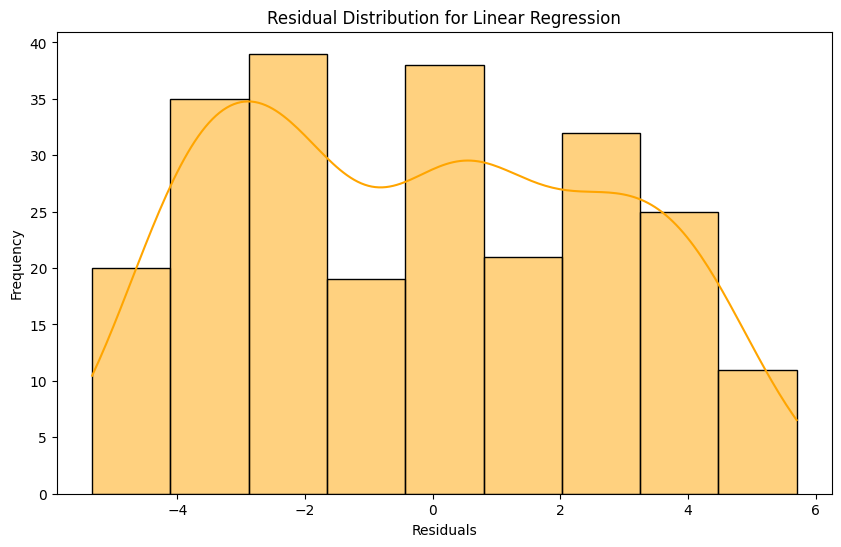

In [111]:
# Visualization of residuals from the Linear Regression model
residual_values = y_test_data - lr_predictions
plt.figure(figsize=(10, 6))
sns.histplot(residual_values, kde=True, color='orange')
plt.title("Residual Distribution for Linear Regression")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

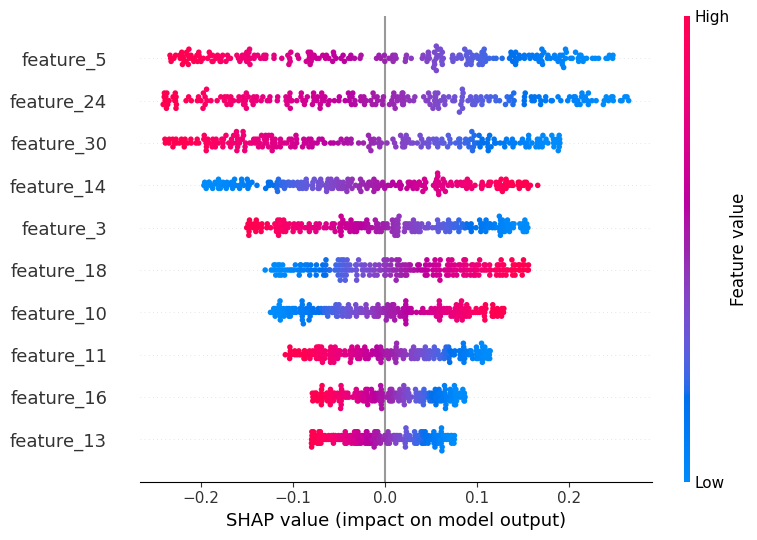

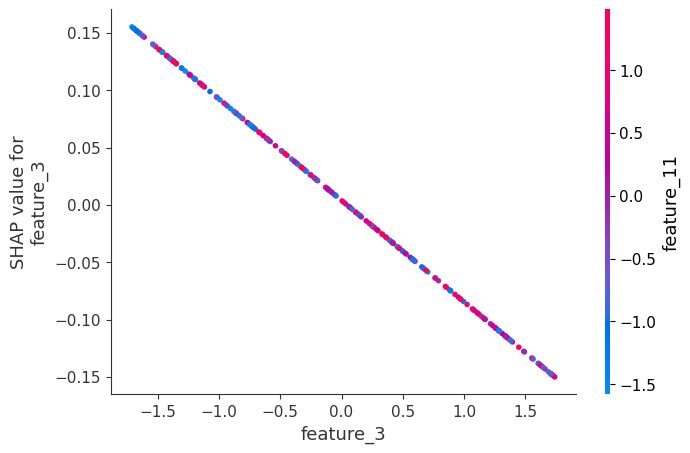

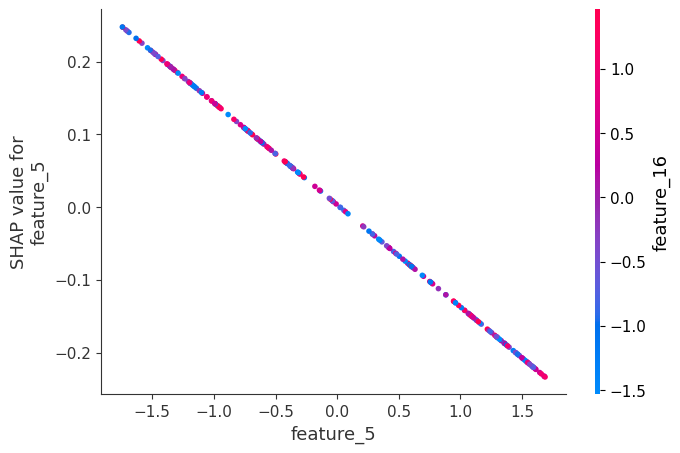

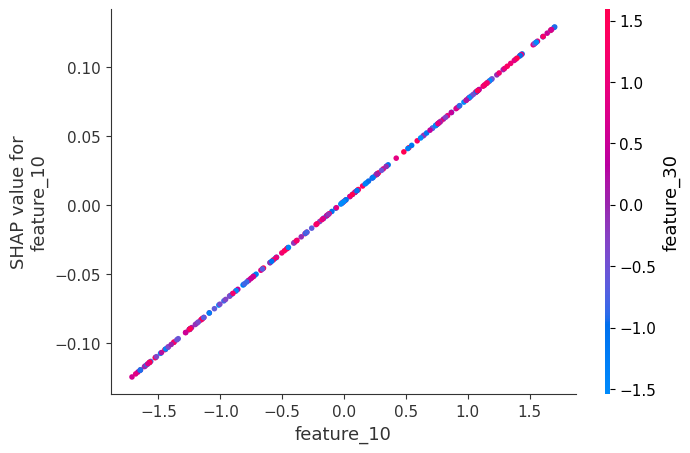

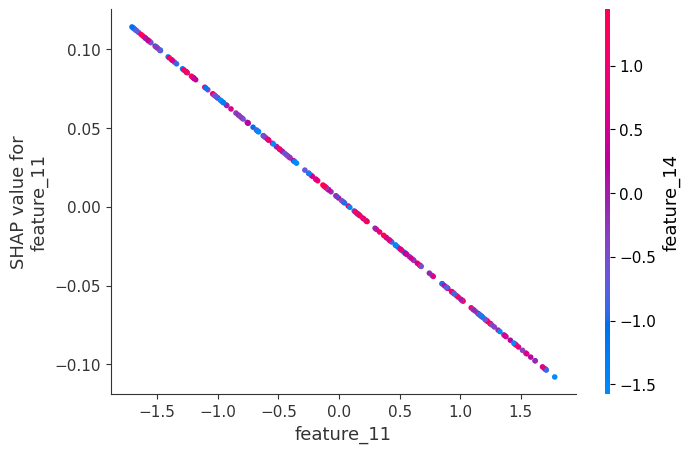

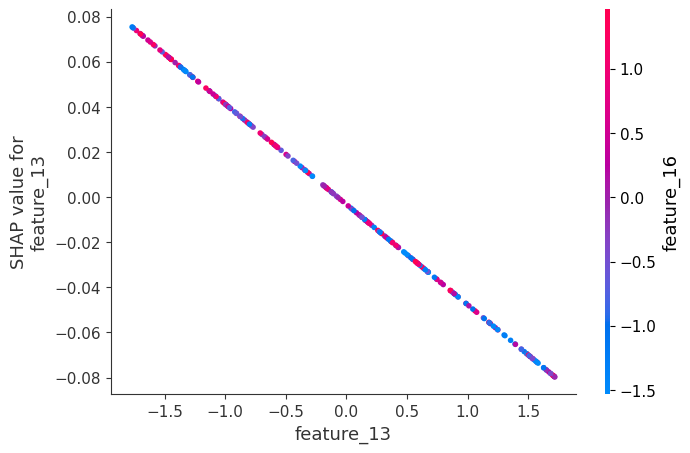

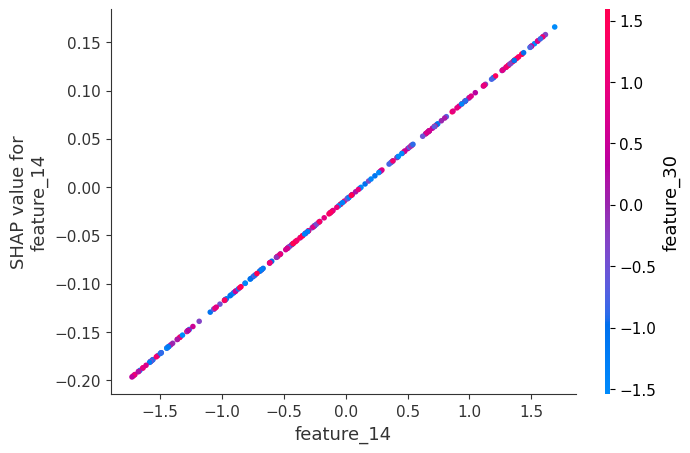

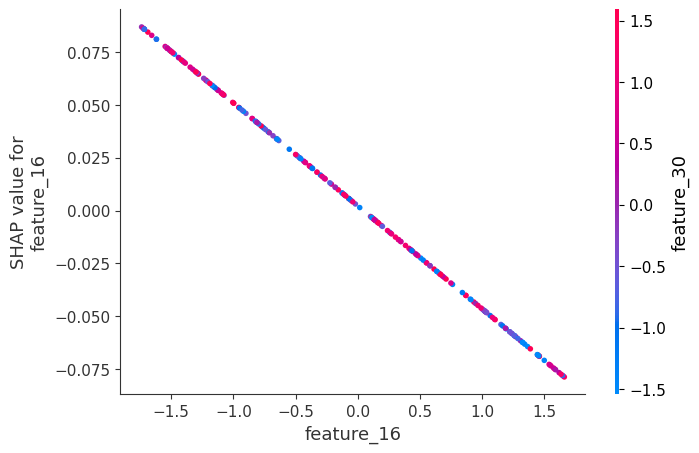

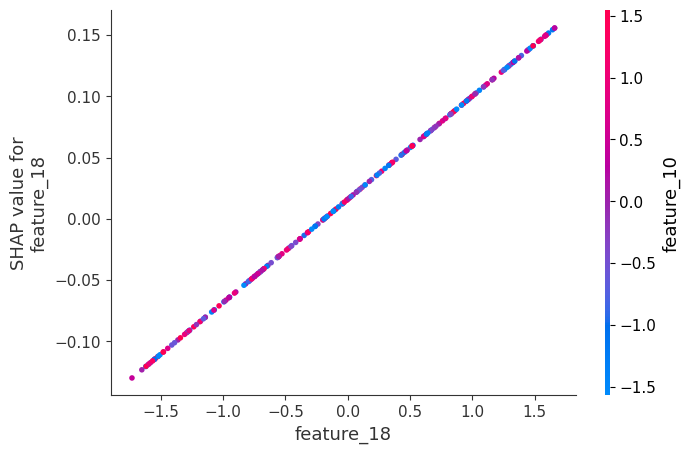

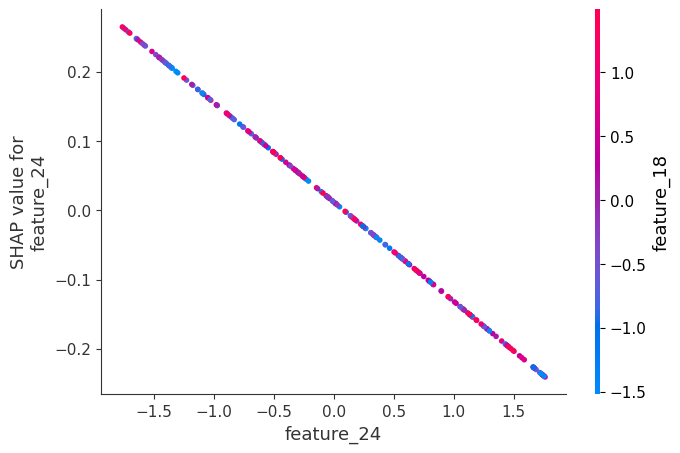

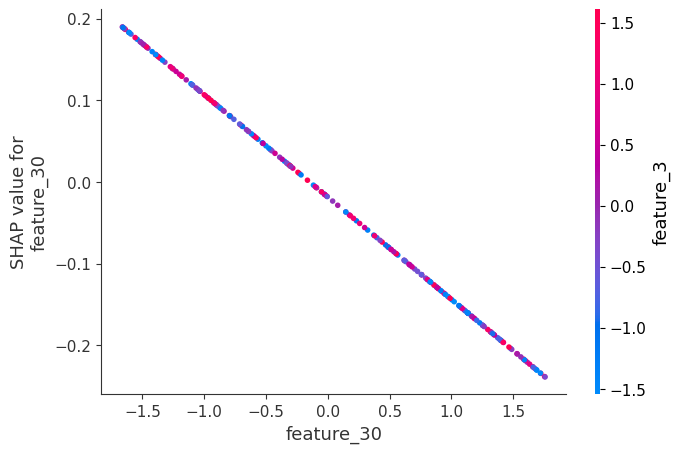

In [112]:
# SHAP analysis
shap_explainer = shap.Explainer(lr_regressor, X_train_data)
shap_values = shap_explainer(X_test_data)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_data, feature_names=selected_features_list)

# SHAP dependence plot for each feature
for idx, feature in enumerate(selected_features_list):
    shap.dependence_plot(idx, shap_values.values, X_test_data, feature_names=selected_features_list)